
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## RBFs validation of historical and synthetic data

inputs required: 
  * Historical nearshore hourly waves
  * Synthetic nearshore hourly waves
  * AWAC ROI buoy data

in this notebook:
  * AWAC buoy - Reconstruction comparison 
  * Syntethic and historical nearshore waves histograms
  * Synthetic and historical waves Extremes
  

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database, hyswan_db

from teslakit.plotting.buoy import scatter_QQ, compare_series
from teslakit.plotting.waves import Plot_Waves_Histogram_FitSim
from teslakit.plotting.extremes import Plot_ReturnPeriodValidation



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('ROI')


In [3]:
# --------------------------------------
# Load nearshore hourly waves for extremes analysis

# Load Buoy variables time series
AWAC = db.Load_AWAC_buoy()


# Historical
HIST_N_h = db.Load_HIST_NEARSHORE(decode_times=True)
#HIST_N_h['time'] = HIST_N_h.indexes['time'].to_datetimeindex()  # need to use numpy.datetime64

# Simulation
SIM_N_h = db.Load_SIM_NEARSHORE_all(decode_times=True, use_cftime=True)



## Methodology Validation: AWAC buoy comparison

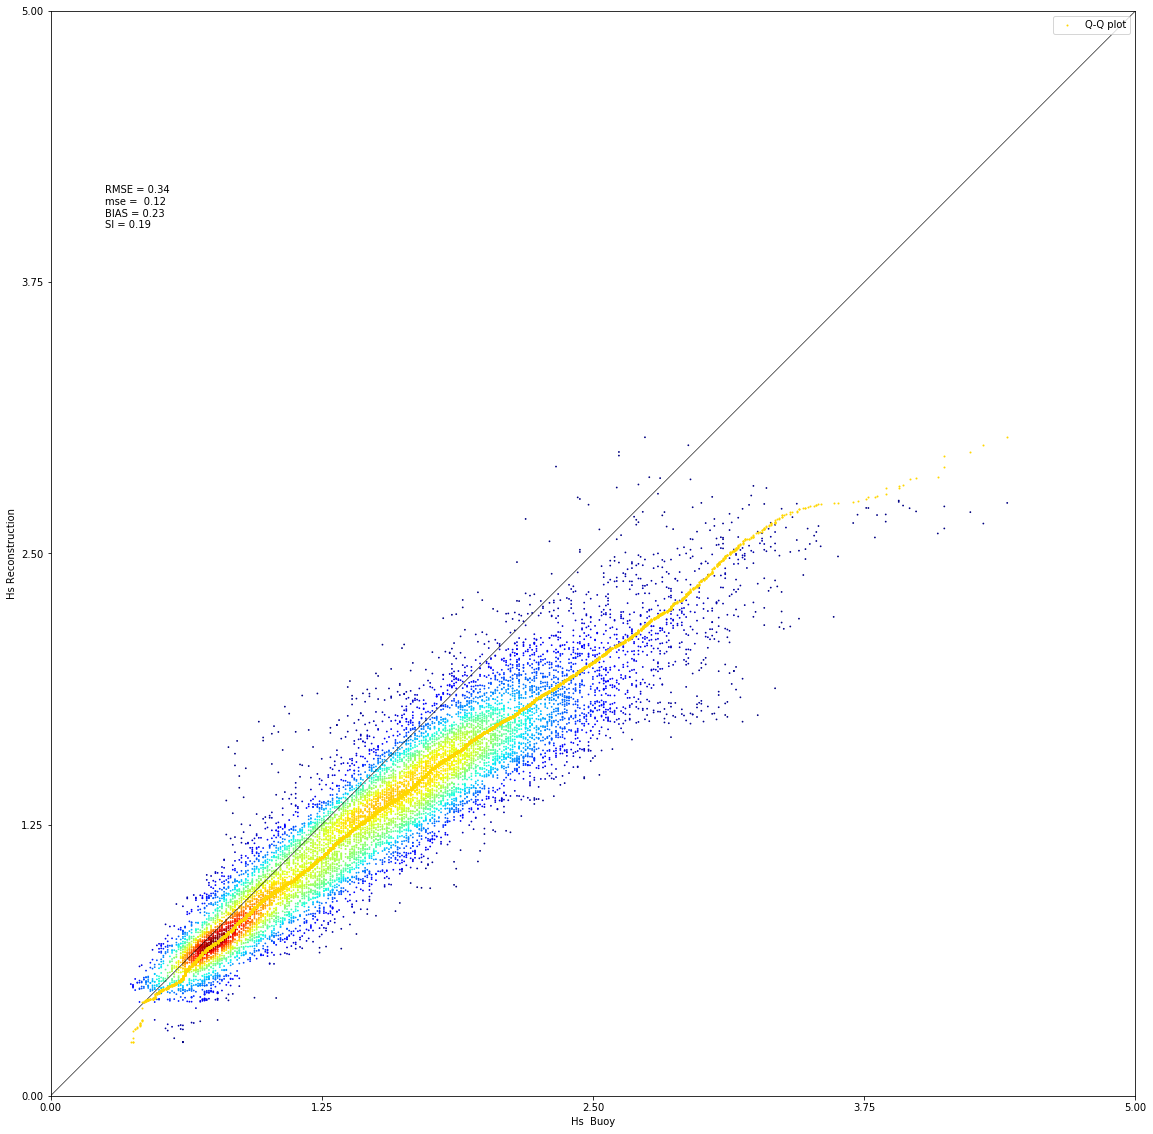

In [4]:
# interpolate waves reconstructed data to buoy times dates
H_interp = HIST_N_h.interp(time=AWAC.time.values[:]) 

# scatter comparison
scatter_QQ(AWAC, H_interp, 'Hs', ' Buoy', 'Reconstruction')


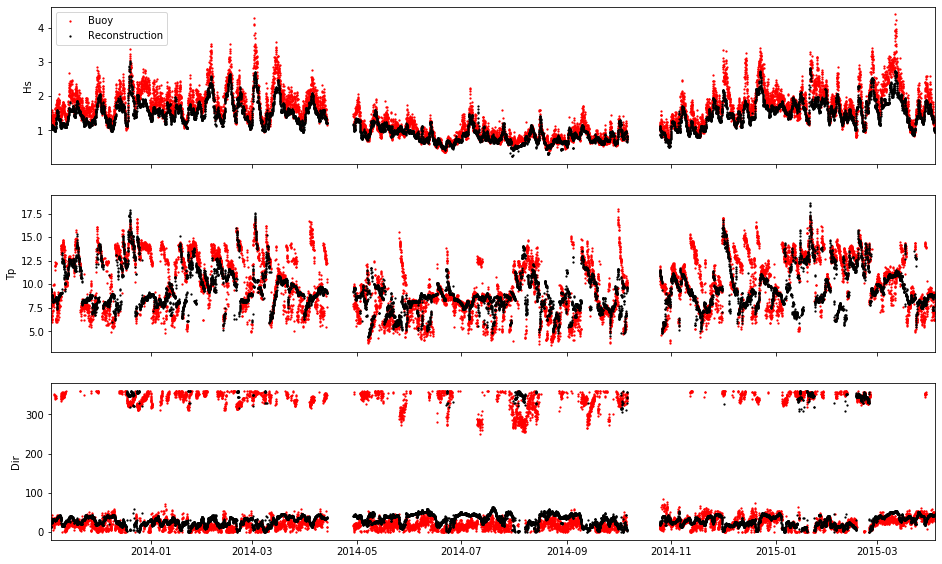

In [5]:
# series comparison
compare_series(AWAC, H_interp, ['Hs', 'Tp', 'Dir'], 'Buoy', 'Reconstruction')



## Methodology Validation: Historical - Simulation Waves Families Comparison

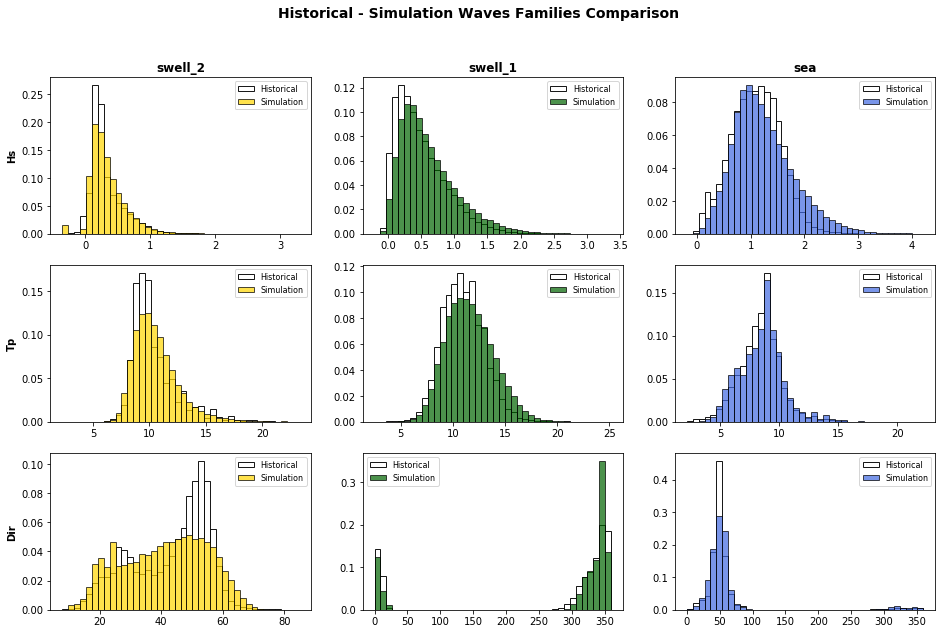

In [6]:
# Compare waves families for reconstructed historical and simulated storms

# get storms from historical reconstruction
#time_storms = HIST_C_h.where(HIST_C_h['max_storms']==True, drop=True).time
#WVS_HIST_rec_s = WVS_HIST_rec.sel(time=time_storms)


# load reconstructed simulation families from hyswan simulations database
db_sim = hyswan_db(db.paths.site.HYSWAN.sim)
WVS_SIM_rec = db_sim.Load('reconstruction')


# Select Simulation to plot storms
n_sim = 0
WVS_SIM_rec_n_s = WVS_SIM_rec.loc[WVS_SIM_rec['n_sim'] == n_sim]

# Plot reconstructed nearshore waves parameters distribution 
Plot_Waves_Histogram_FitSim(HIST_N_h, WVS_SIM_rec_n_s);



## Methodology Validation: AWL Nearshore - Annual Maxima Return Period

In [7]:
# def. some auxiliar function to select all dataset variables at vn max by groups

def grouped_max(ds, vn=None, dim=None):
    return ds.isel(**{dim: ds[vn].argmax(dim)})


In [8]:
# Historical AWL Annual Maxima

# calculate AWL annual maxima dataset
hist_AMax = HIST_N_h.groupby('time.year').apply(grouped_max, vn='AWL', dim='time')


In [9]:
# Simulation AWL Annual Maxima

# replace nans by 0
SIM_N_nonan = SIM_N_h.fillna(0)

# calculate AWL annual maxima dataset
sim_AMax = SIM_N_nonan.groupby('time.year').apply(grouped_max, vn='AWL', dim='time')


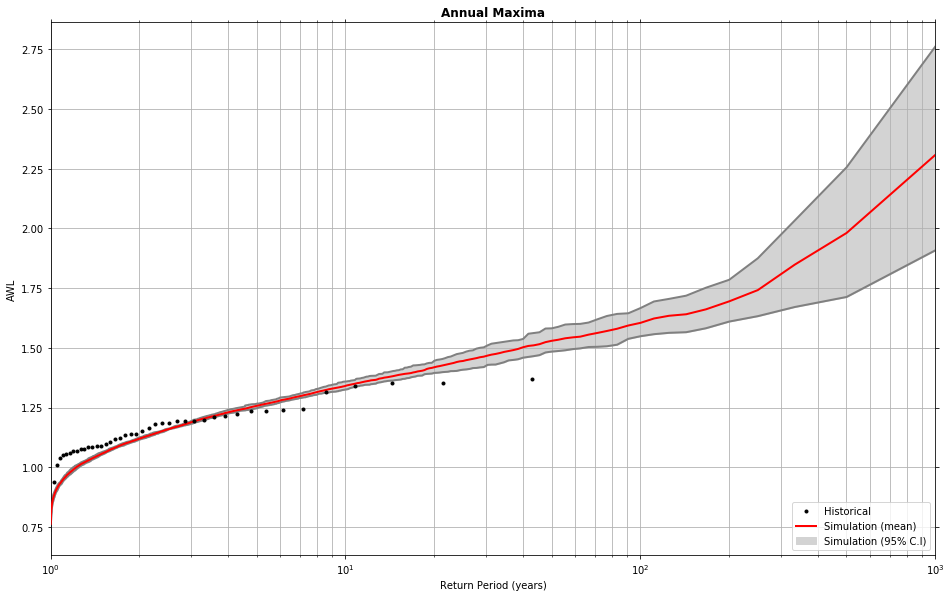

In [10]:
# AWL Annual Maxima Return Period (historical vs. simulations)

Plot_ReturnPeriodValidation(hist_AMax['AWL'], sim_AMax['AWL'].transpose());


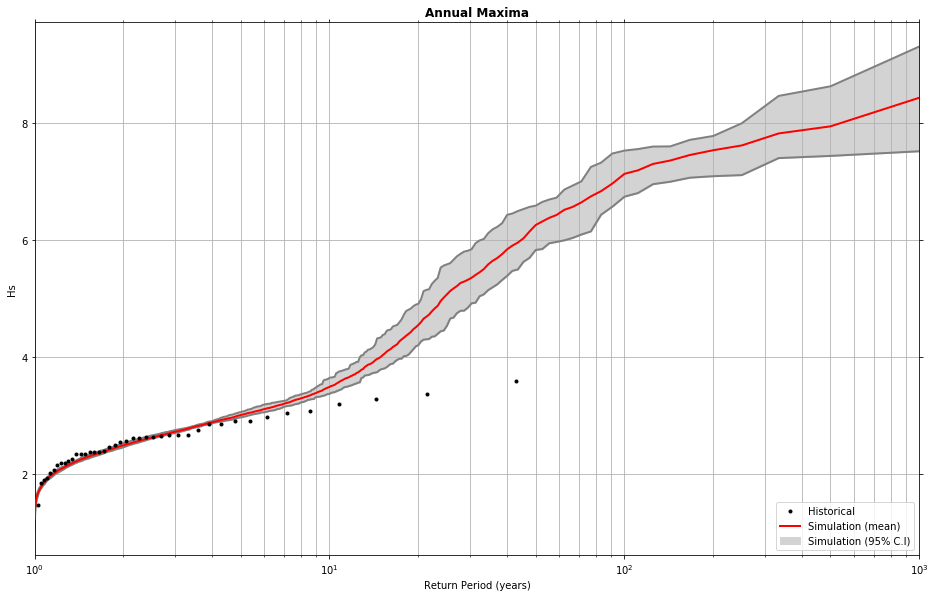

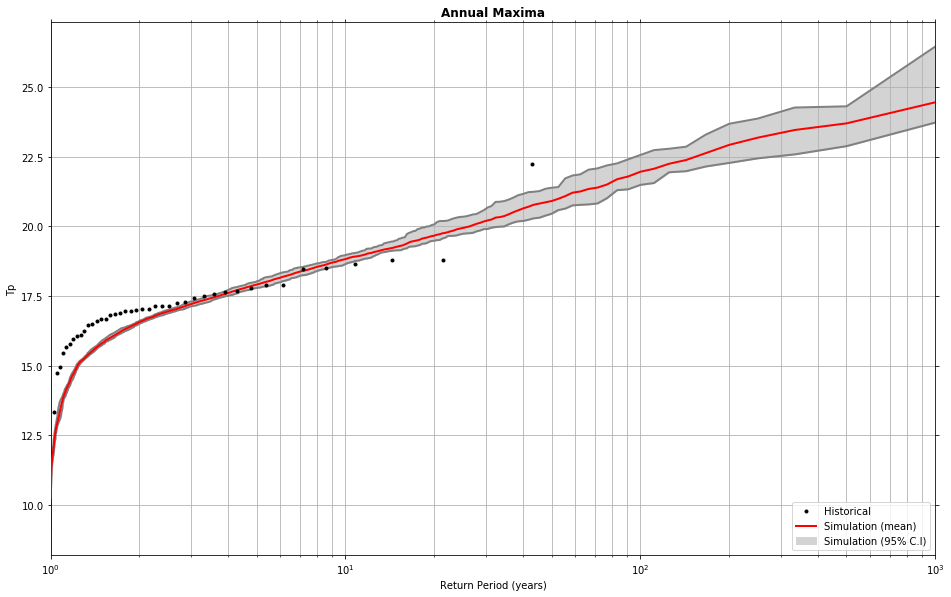

In [11]:
# Hs and Tp Return Period (historical vs. simulations) at AWL Annual Maxima

# Hs at AWL Annual Maxima
Plot_ReturnPeriodValidation(hist_AMax['Hs'], sim_AMax['Hs'].transpose());

# Tp at AWL Annual Maxima
Plot_ReturnPeriodValidation(hist_AMax['Tp'], sim_AMax['Tp'].transpose());



## Hs Nearshore - Annual Maxima Return Period

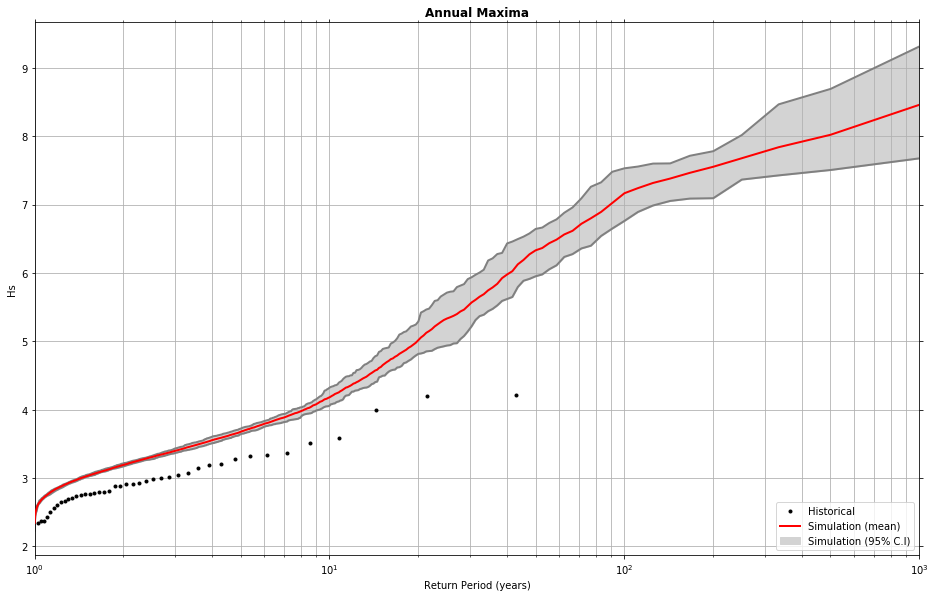

In [12]:
# calculate Annual Maxima values for historical and simulated data
hist_A = HIST_N_h['Hs'].groupby('time.year').max(dim='time')
sim_A = SIM_N_h['Hs'].groupby('time.year').max(dim='time')

# Return Period historical vs. simulations
Plot_ReturnPeriodValidation(hist_A, sim_A.transpose());



## Tp Nearshore - Annual Maxima Return Period

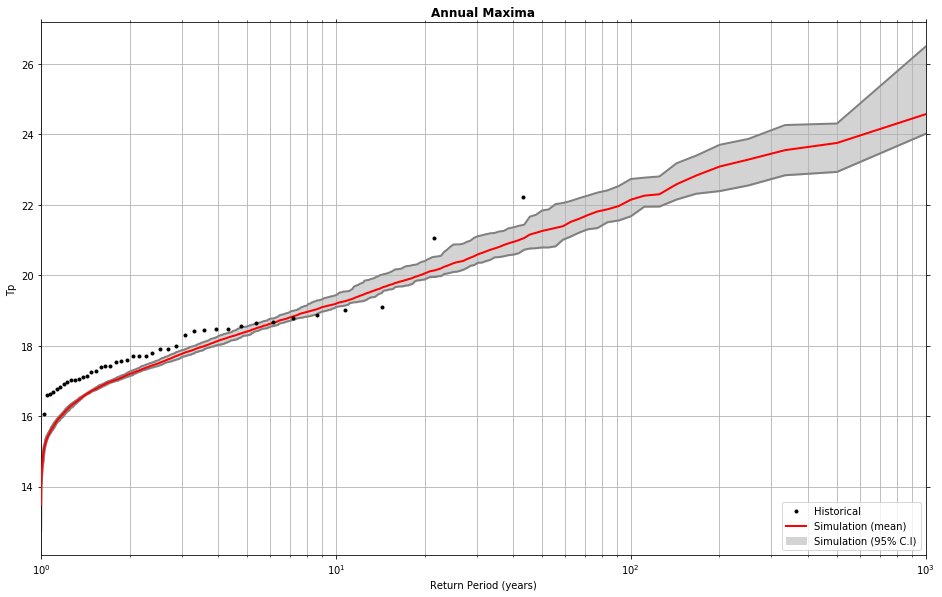

In [13]:
# calculate Annual Maxima values for historical and simulated data
hist_A = HIST_N_h['Tp'].groupby('time.year').max(dim='time')
sim_A = SIM_N_h['Tp'].groupby('time.year').max(dim='time')

# Return Period historical vs. simulations
Plot_ReturnPeriodValidation(hist_A, sim_A.transpose());
